In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# 生成对抗示例

**Author:** [Nathan Inkawhich](https://github.com/inkawhich)_

本教程将提高您对ML（机器学习）模型的安全漏洞的认识，并将深入了解对抗性机器学习的热门话题。您可能会惊讶地发现， 为图像添加难以察觉的扰动会导致模型性能大不相同。鉴于这是一个教程，我们将通过图像分类器上的示例探讨该主题。具体来说，我们将 使用第一种也是最流行的攻击方法之一，即快速梯度符号攻击算法（FGSM）来迷惑 MNIST 分类器。


## 威胁模型

对于上下文，有许多类别的对抗性攻击，每种攻击具有不同的目标和对攻击者知识的假设。然而，通常，总体目标是向输入数据添加最少 量的扰动以引起期望的错误分类。对攻击者的知识有几种假设，其中两种是：白盒子和黑盒子。白盒攻击假定攻击者具有对模型的全部 知识和访问权限，包括体系结构、输入、输出和权重。黑盒攻击假设攻击者只能访问模型的输入和输出，并且对底层架构或权重一无所知。 还有几种类型的目标，包括错误分类和源/目标错误分类。错误分类的目标意味着攻击者只希望输出分类错误，但不关心新分类是什么。 源/目标错误分类意味着攻击者想要更改最初属于特定源类的图像，以便将其归类为特定目标类。

FGSM 攻击是一种白盒攻击，其目标是错误分类。有了这些背景信息，我们现在可以详细讨论攻击。

## Fast Gradient Sign Attack

FGSM（Fast Gradient Sign Attack）
快速梯度标志攻击（FGSM），是迄今为止最早和最受欢迎的对抗性攻击之一，它由 Goodfellow 等人在[Explaining and Harnessing Adversarial Examples] (https://arxiv.org/abs/1412.6572)中提出，是一种简单但是有效的对抗样本生成算法。它旨在通过利用模型学习的方式和渐变来攻击神经 网络。这个想法很简单，攻击调整输入数据以基于相同的反向传播梯度来最大化损失，而不是通过基于反向传播的梯度调整权重来最小化损失。 换句话说，攻击是利用损失函数的梯度，然后调整输入数据以最大化损失。

在进入代码之前，先讲一下著名的 FGSM 熊猫示例并提取一些符号。

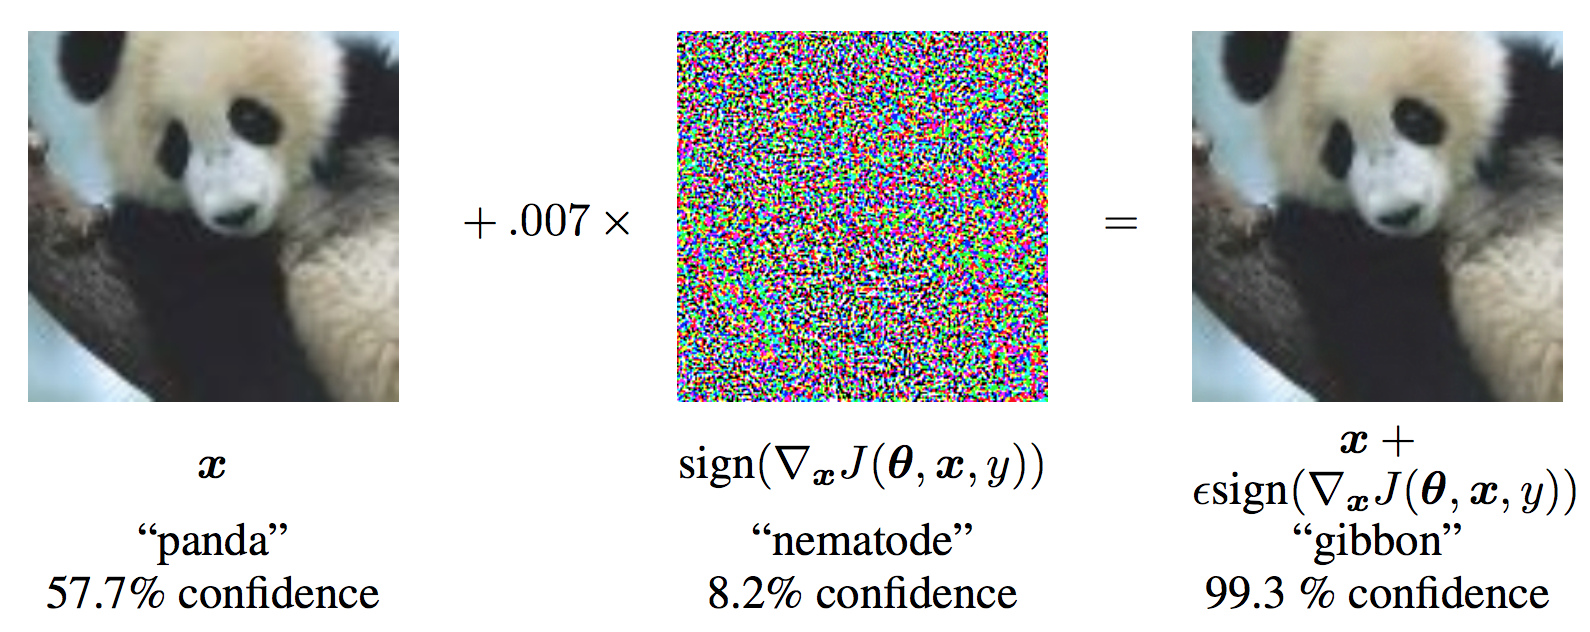

From the figure, $\mathbf{x}$ is the original input image
correctly classified as a “panda”, $y$ is the ground truth label
for $\mathbf{x}$, $\mathbf{\theta}$ represents the model
parameters, and $J(\mathbf{\theta}, \mathbf{x}, y)$ is the loss
that is used to train the network. The attack backpropagates the
gradient back to the input data to calculate
$\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$. Then, it adjusts
the input data by a small step ($\epsilon$ or $0.007$ in the
picture) in the direction (i.e.
$sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$) that will
maximize the loss. The resulting perturbed image, $x'$, is then
*misclassified* by the target network as a “gibbon” when it is still
clearly a “panda”.

Hopefully now the motivation for this tutorial is clear, so lets jump
into the implementation.




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 实现

在本节中，我们将讨论教程的输入参数，定义被攻击的模型，然后编写攻击代码并运行一些测试。

### Inputs

三个输入：

-  ``epsilons`` - 用于运行的epsilon值列表。在列表中保留0非常重要，因为它表示原始测试集上的模型性能。而且，我们期望epsilon越大，扰 动就越明显，但就降低模型精度方面而言攻击越有效。由于此处的数据范围为[0,1]，因此epsilon值不应超过1。

-  ``pretrained_model`` - 预训练的MNIST模型路径。为简单起见，请在[此处](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing) 下载预训练模型。

-  ``use_cuda`` - 如果需要和可使用CUDA的bool标志。注意，带有CUDA的GPU对本教程并不重要，因为本教程使用CPU不会花费太多时间。




In [6]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "../../data/lenet_mnist_model.pth.pt"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

### 被攻击的模型

如上所述，受攻击的模型与[pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist)中的 MNIST 模型 相同。您可以训练并保存自己的 MNIST 模型，也可以下载并使用提供的模型。此处的 Net 定义和测试数据加载器已从 MNIST 示例中复制。 本小节的目的是定义模型和数据加载器，然后初始化模型并加载预训练的权重。

In [7]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### FGSM 算法攻击

现在，我们可以通过扰乱原始输入来定义创建对抗性示例的函数。fgsm_attack函数有三个输入
- *image* 原始的未扰动图像 ($x$), 
- *epsilon* 是像素方式的扰动量 ($\epsilon$), 
- and *data_grad*是 输入图像的损失梯度。
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$).

然后该功能将扰动图像创建为

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}

最后，为了保持数据的原始范围，将扰动的图像剪切到范围[0,1]。




In [8]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

### Testing Function

最后，本教程的核心结果来自测试功能。每次调用此测试函数都会对 MNIST 测试集执行完整的测试步骤，并报告最终的准确性。但是，请注意，此函数也需要输入($\epsilon$)。这是因为test函数展示受到强度为($\epsilon$)的攻击下被攻击模型的准确性。 更具体地说，对于测试集中的每个样本，该函数计算输入数据($data\_grad$)的损失梯度，用fgsm_attack（perturbed_data） 创建扰乱图像，然后检查扰动的例子是否是对抗性的。除了测试模型的准确性之外，该函数还保存并返回一些成功的对抗性示例，以便稍后可视化。

In [9]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Run Attack

实施的最后一部分是实际运行攻击。在这里，我们对epsilons输入中的每个epsilon值运行一个完整的测试步骤。对于每个epsilon，我们还保存最终的准确率和一些成功的对抗性示例，以在接下来的部分中绘制。请注意，随着epsilon值的增加，打印的准确率会下降。此外，注意到当ϵ=0时，表示原始测试准确率，没有攻击。


In [10]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.05	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.1	Test Accuracy = 8743 / 10000 = 0.8743
Epsilon: 0.15	Test Accuracy = 7108 / 10000 = 0.7108
Epsilon: 0.2	Test Accuracy = 4874 / 10000 = 0.4874
Epsilon: 0.25	Test Accuracy = 2710 / 10000 = 0.271
Epsilon: 0.3	Test Accuracy = 1420 / 10000 = 0.142


## Results

### Accuracy vs Epsilon

The first result is the accuracy versus epsilon plot. As alluded to
earlier, as epsilon increases we expect the test accuracy to decrease.
This is because larger epsilons mean we take a larger step in the
direction that will maximize the loss. Notice the trend in the curve is
not linear even though the epsilon values are linearly spaced. For
example, the accuracy at $\epsilon=0.05$ is only about 4% lower
than $\epsilon=0$, but the accuracy at $\epsilon=0.2$ is 25%
lower than $\epsilon=0.15$. Also, notice the accuracy of the model
hits random accuracy for a 10-class classifier between
$\epsilon=0.25$ and $\epsilon=0.3$.




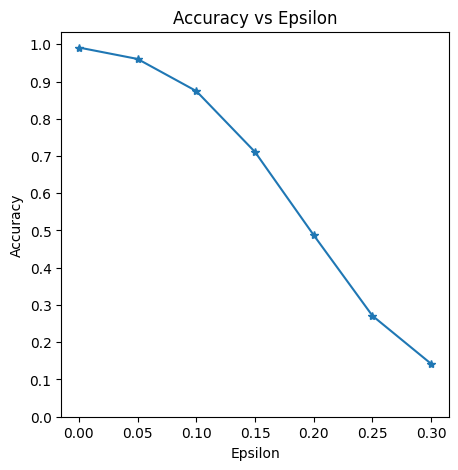

In [11]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversarial Examples

Remember the idea of no free lunch? In this case, as epsilon increases
the test accuracy decreases **BUT** the perturbations become more easily
perceptible. In reality, there is a tradeoff between accuracy
degradation and perceptibility that an attacker must consider. Here, we
show some examples of successful adversarial examples at each epsilon
value. Each row of the plot shows a different epsilon value. The first
row is the $\epsilon=0$ examples which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\epsilon=0.15$ and are
quite evident at $\epsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.




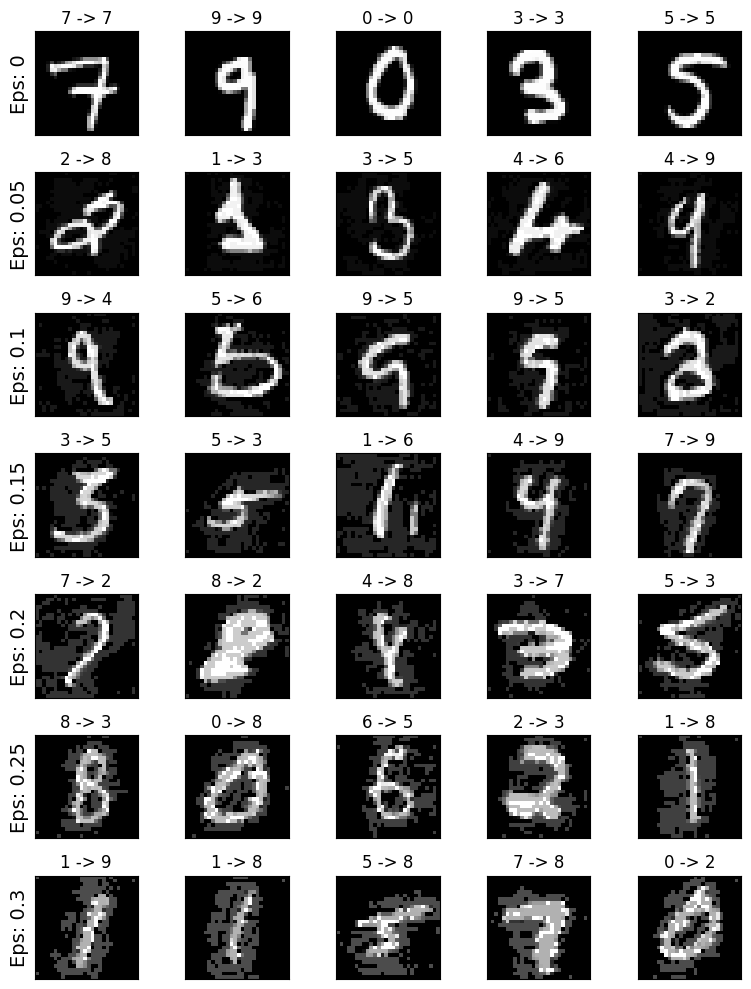

In [12]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Where to go next?

Hopefully this tutorial gives some insight into the topic of adversarial
machine learning. There are many potential directions to go from here.
This attack represents the very beginning of adversarial attack research
and since there have been many subsequent ideas for how to attack and
defend ML models from an adversary. In fact, at NIPS 2017 there was an
adversarial attack and defense competition and many of the methods used
in the competition are described in this paper: [Adversarial Attacks and
Defences Competition](https://arxiv.org/pdf/1804.00097.pdf)_. The work
on defense also leads into the idea of making machine learning models
more *robust* in general, to both naturally perturbed and adversarially
crafted inputs.

Another direction to go is adversarial attacks and defense in different
domains. Adversarial research is not limited to the image domain, check
out [this](https://arxiv.org/pdf/1801.01944.pdf)_ attack on
speech-to-text models. But perhaps the best way to learn more about
adversarial machine learning is to get your hands dirty. Try to
implement a different attack from the NIPS 2017 competition, and see how
it differs from FGSM. Then, try to defend the model from your own
attacks.

A further direction to go, depending on available resources, is to modify
the code to support processing work in batch, in parallel, and or distributed
vs working on one attack at a time in the above for each ``epsilon test()`` loop.


